In [62]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft
import xarray as xr
import pandas as pd
import netCDF4 as nc
import shutil
import importlib
from scipy import signal
import math
# import local modules
if __name__ == '__main__' and __package__ is None:
    from os import sys, path
    sys.path.append(path.dirname(path.dirname(path.dirname(path.abspath("__file__")))))
import pytechsas.sensor.techsas_gravi_process as tgravi

import bokeh as bk
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
output_notebook()

Loading BokehJS ...

In [5]:
base_path = "F://03_gravi_mag//02 dataset//18002498_MANTA_RAY_2022//test_2023-10"
file = base_path + "//GRAVI_MANTA-RAY-2022_KSS-AT_KSS31M_01_processed_cut.gravi.nc"

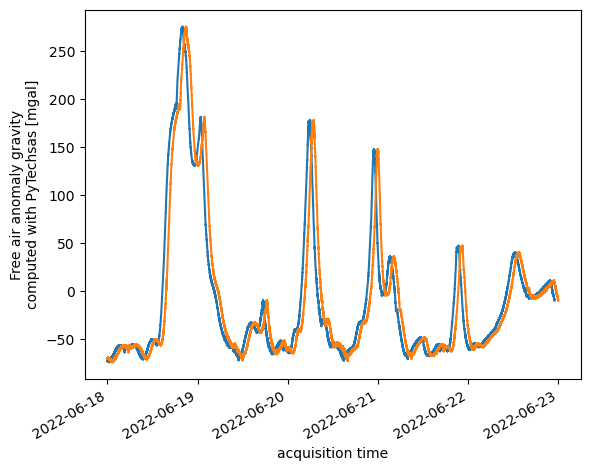

In [29]:
with xr.open_dataset(file) as ds:
    
    #ds["computed_free_air_anomaly"].plot()
    previous = ds["computed_free_air_anomaly"]
    
    time_delta = np.timedelta64(int(3600), "s")
    shifted_ds = ds.assign_coords(time=ds.time - time_delta)
    #shifted_ds["computed_free_air_anomaly"].plot()
    
    interp_shifted_ds = shifted_ds.interp_like(ds)
    interp_shifted_ds["computed_free_air_anomaly"].plot()
    previous.plot()

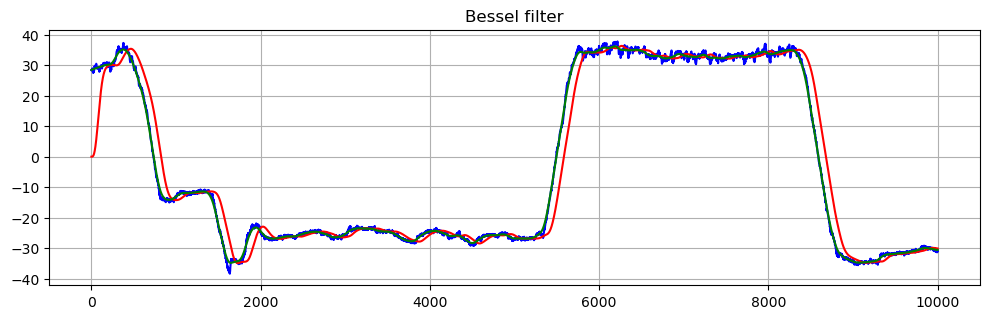

In [99]:
input_data = data[20000:30000].values
order = 4
fc = 1/175 # critical frequency in Hz
fs = 1 # sampling frequency

b_bessel, a_bessel = signal.bessel(N=1, Wn=fc, btype ='low', fs=fs)#, analog=True)
filtered_data_1 = signal.lfilter(b_bessel, a_bessel, input_data)

b_bessel, a_bessel = signal.bessel(N=order, Wn=fc, btype ='low', fs=fs)
filtered_data_4 = signal.lfilter(b_bessel, a_bessel, input_data)

b, a = signal.bessel(N=2, Wn=fc, btype ='low', fs=fs)
filtfilt_data = signal.filtfilt(b, a, input_data)


#b_bessel_d, a_bessel_d = signal.bessel(N=order, Wn=175, btype ='low', fs=fs, norm='delay')#, analog=True)
#filtered_data_d = signal.lfilter(b_bessel_d, b_bessel_d, input_data.values)

# Affichage du signal d'entrée et du signal filtré
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(input_data, 'b-', label='input')
#plt.plot(filtered_data_1, 'y-', label='filtered')
plt.plot(filtered_data_4, 'r-', label='filtered')
plt.plot(filtfilt_data, 'g-', label='filtered')

#plt.plot(filtered_data_d, 'g-', label='filtered2')
plt.title('Bessel filter')
plt.grid(True)

plt.tight_layout()
plt.show()

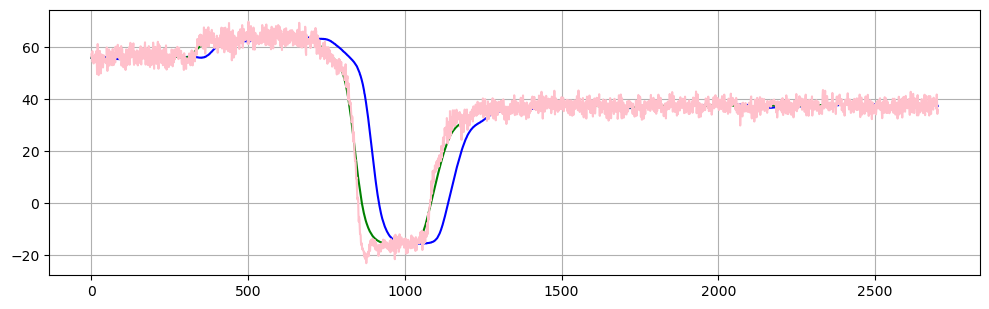

max_correlation_index: 2668
len(eoetvoes_gravi): 2701
Déphasage en sample_shift: 32
Déphasage en secondes: 64.0


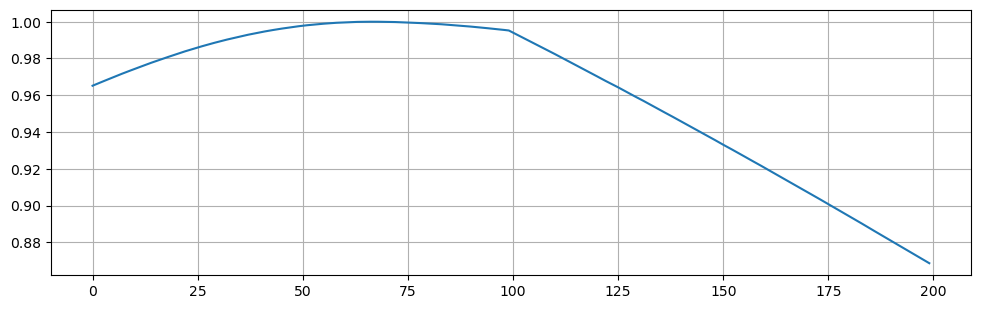

In [196]:
file_path = "F://03_gravi_mag//02 dataset//14000800_SALSA-LEG1//test_10_04//201400080045-KSS-AT_KSS31M_cut.gravi.nc"
with xr.open_dataset(file_path) as ds:
    ds = ds.sel(time=slice("2014-04-29 07:00:00", "2014-04-29 08:30:00"))
    eotvos_gravi = ds['eoetvoes'] - ds['gravity']

    eotvos_nav = ds['computed_eotvos_correction']
    b, a = signal.bessel(N=2, Wn=1/175, btype='low', fs=1)  
    eotvos_nav_filtered = signal.filtfilt(b, a, eotvos_nav)
    b, a = signal.bessel(N=4, Wn=1/175, btype='low', fs=1)  
    eotvos_nav_filtered_4 = signal.filtfilt(b, a, eotvos_nav)
    
    # shift eotvos
    filter_delay = 109
    time_delta = np.timedelta64(int(filter_delay), "s")
    eotvos_gravi_shifted = eotvos_gravi
    eotvos_gravi_shifted = eotvos_gravi_shifted.assign_coords(time=ds.time - time_delta)
    eotvos_gravi_shifted = eotvos_gravi_shifted.interp_like(ds)

# Affichage du signal d'entrée et du signal filtré
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(eotvos_gravi, 'b-', label='eoetvoes_gravi')
plt.plot(eotvos_gravi_shifted, 'g-', label='eotvos_nav_shifted')
plt.plot(eotvos_nav, 'pink', label='eoetvoes_nav')
#plt.plot(eotvos_nav_filtered, 'r', label='eoetvoes_nav')
#plt.plot(eotvos_nav_filtered_4, 'orange', label='eoetvoes_nav_4')
plt.grid(True)
plt.tight_layout()
plt.show()

corr = signal.correlate(eotvos_nav, eotvos_gravi)
lags = signal.correlation_lags(len(eotvos_gravi), len(eotvos_nav))
corr /= np.max(corr)

max_correlation_index = np.argmax(corr)
print("max_correlation_index:", max_correlation_index)
print("len(eoetvoes_gravi):", len(eotvos_gravi))
sample_shift = len(eotvos_gravi) - 1 - max_correlation_index
print("Déphasage en sample_shift:", sample_shift)
fs = 0.5
time_shift_seconds = sample_shift / fs
print("Déphasage en secondes:", time_shift_seconds)


plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
#plt.plot(corr)
plt.plot(corr[len(eotvos_gravi)-100:len(eotvos_gravi)+100])
#plt.plot(eotvos_nav_filtered, 'r', label='eoetvoes_nav')
#plt.plot(eotvos_nav_filtered_4, 'orange', label='eoetvoes_nav_4')
plt.grid(True)
plt.tight_layout()
plt.show()

In [155]:
from scipy.signal import correlate
from scipy.signal import correlation_lags

In [118]:
cross_correlation.mean()

2055268.3446638293

In [116]:
# Calcul de la corrélation croisée
cross_correlation = correlate(eoetvoes_gravi, eotvos_nav_filtered, mode='full')

# Le décalage en échantillons où la corrélation est maximale
max_correlation_index = np.argmax(cross_correlation)
sample_shift = len(eoetvoes_gravi) - 1 - max_correlation_index

print("max_correlation_index", max_correlation_index)
print("Déphasage en sample_shift:", sample_shift)
# Conversion en secondes en utilisant la fréquence d'échantillonnage
fs = 100
time_shift_seconds = sample_shift / fs

print("Déphasage en secondes:", time_shift_seconds)

max_correlation_index 2681
Déphasage en sample_shift: 920
Déphasage en secondes: 9.2


In [70]:
phase_difference = np.angle(spectrum1) - np.angle(spectrum2)

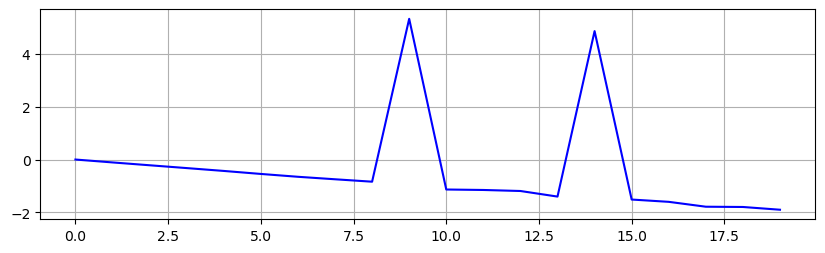

In [75]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(phase_difference[:20], 'b-', label='input')
#plt.plot(spectrum2[:20], 'r-', label='filtered')
#plt.plot(filtered_data_d, 'g-', label='filtered2')
plt.grid(True)